0.7955642875768925


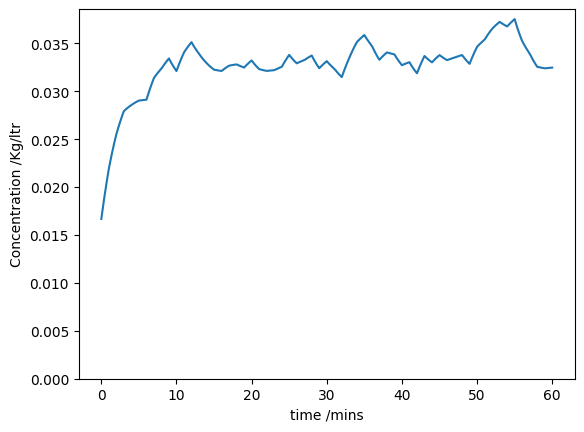

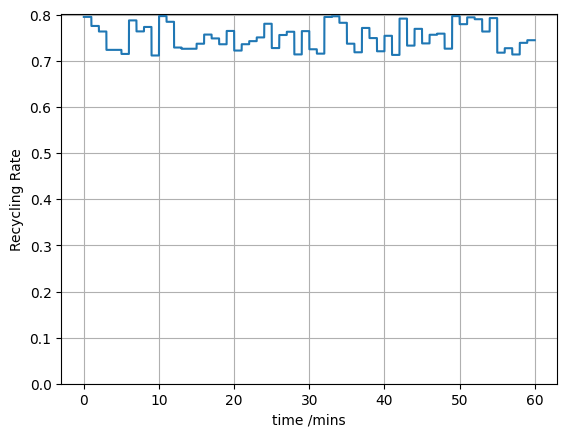

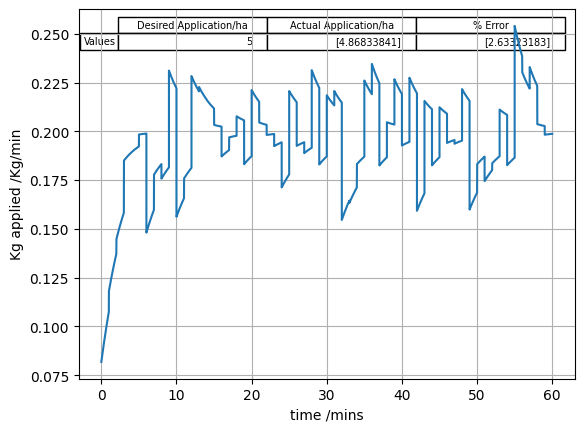

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr  9 12:04:34 2025

@author: thoma
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import array as arr
from scipy import signal
import random

#set randomstate
np.random.seed(42)

#########INPUTS#########
Tractor_Speed=6 #Tractor Speed in Kph
Row_Spacing=2 #Aveage spacing between rows /m
No_Faces=4 # Number of faces sprayed (so a 2 tunnel lipco=4 faces)
Desired_kgperha=5 #Desired application rate kg.ha
Desired_lperha=600 #Desired liquid discharge rate l/ha
Qin=50 #Maximum Flow rate of the clean water into the tank when solenoid is open
Tv=20 #tank size /l
R=0.2# Recycling rate /Ratio 0->1 (Overwritten by recycling vector if left uncommented)
Rini=0.5 #Recycling initial guess /Ratio 0->1

##########RECYCLING RATE RANGE #######
MaxR=0.8 #maximum value of recycling
MinR=0.71#minimum value of recycling



###############Standard spray session calcs from lipco manual###################
rowsperha=100/Row_Spacing # Calcualte number of rows per hectare
Qn=(Tractor_Speed*Row_Spacing*Desired_lperha*(No_Faces/2))/600 #Flow out of the nozzles /lpm
lengthha=rowsperha*100*2/No_Faces #Length of travel of the tractor /m
timeperha=lengthha/(1000*(Tractor_Speed/60**2))/60 #time spent per hectare /min

#############Mixer specific initial condition calcs####################
Kgr=Desired_kgperha/timeperha #Desired rate of application

Kgini=(1/(1-Rini))*Tv*Kgr/Qn# Initial Kg in tank /kg calculated from initial guess of recycling rate

###################Create time vector####################################
endt=60 #Length of time vecotr in mins
st=0.001 #time step /min
t=np.arange(0, endt, st) #Creating a time vector length endt with time step st
#######################Initialising vectors################################

l=len(t)+1
Qwl=[0] * l
Kglive=[0] * l
Kgfout=[0] * l
Conc=[0] * l
KgfR=[0] * l
Kgadded=[0] * l
Kgideal=[0] * l
Kgfrapp=[0] * l
Tl=[0] * l
Solop=[0] * l
Kgapp=[0]

#######################Creation of a recycling vector################################
# Creation of a recycling vector rather than a contant value (comment it out and it will just use the value above but make sure to clear variables first)
# Vecotor is a simple suqare wave with min and max values based on the values below, the frequency is based on makeing the number of turns a tractor would 
no_rows=100/Row_Spacing
rowspermin=timeperha/no_rows
# R=signal.square(2*np.pi*t*rowspermin,duty=0.1) #make a square wave 
R=np.random.uniform(MinR,MaxR,l//100)
# R[R>0] = MaxR
# R[R<0] = MinR
# R=(((signal.square(t,duty=0.25)+1)/2)+0.1)*0.7
R=np.concatenate((R, np.array([MinR])))
temp = np.zeros(l)
j = 0
for i in range(len(R)):
    temp[j:j+1000] = R[i]
    j = i*1000
R = temp
print(R[120])
###################set initial values###################################

#set initial values of kglive (number of kilos in tank) and Conc (concentration of tank)
Kglive[0]=Kgini
Conc[0]=Kgini/Tv
Tl[0]=Tv

##################################Simulation Loop###########################
ii=1

#loop over the time vector t using index ii (ii is manually iterated because im bad at python #MATLABFORLIFE)
# nomenclature, Kgf___ kg rate so kg/min, kg___ just kg left in system so kg 

for x in t:
    
    
    Kgfout[ii]=Conc[ii-1]*Qn #Calculate the number of kg of treatment leaving the nozzles per min
    
    KgfR[ii]=Kgfout[ii]*R[ii] #Calculate the number of kg of treatment being recycled per min
    
    Kgfrapp[ii]=Kgfout[ii]-KgfR[ii] #Calculate the number of kg being actually applied (what we care about) in kg/min
    

    Kglive[ii]=Kglive[ii-1]+Kgr*st-Kgfrapp[ii]*st  #Update the remaining kg in the tank
    # Kg in tank = previous value of kg in tank + kg applied with contatnt dosing rate (Kgr) - kg actually applied to leaves (all converted to kg only by multiplying by time step st)
    
    Kgapp=Kgapp+Kgfrapp[ii]*st #update the total number of kg applied (as i CBA to to an integration after the fact)
    
    Conc[ii]=Kglive[ii]/Tv #update live tank concentration
            
    ii=ii+1
    
##############################Soelnoid Behaviour loop###############################
#Soelnoid Behaviour loop, can be used to check the behaviour of 100% recycling behaviour when booms are off
ii=1   

for x in t:    
    
    Tl[ii]=Tl[ii-1]-st*Qn*(1-R[ii]) #Calculate live tank weight
        
    if Tl[ii]<20: #Loop which opens the solenoid if the tank weight is below the target weight (20)
        Solop[ii]=1 # Vector of on off state for solenoid into tank 
        Tl[ii]=Tl[ii]+Qin*st
    
    ii=ii+1

###########################Accuracy of application calcs######################
HaCovered=endt/timeperha # Calculate the number of hectares actually covered over whole session
Actualkgperha=Kgapp/HaCovered # Calculate the true kg/ha number applied in reality
Perc_error=100*(1-Actualkgperha/Desired_kgperha) #Percentage error of desired vs actual application rate 


#plot some shit    
plt.figure(1)
plt.plot(t[1:len(t)],Conc[1:len(t)])
plt.xlabel('time /mins')
plt.ylabel('Concentration /Kg/ltr')
plt.gca().set_ylim(bottom=0)

plt.figure(2)
plt.plot(t[1:len(t)],R[1:len(t)])
plt.xlabel('time /mins')
plt.ylabel('Recycling Rate')
plt.gca().set_ylim(bottom=0)

plt.grid(1)
plt.figure(3)#
plt.plot(t[1:len(t)],Kgfrapp[1:len(t)])
plt.grid(1)
plt.xlabel('time /mins')
plt.ylabel('Kg applied /Kg/min')
# plt.ylim((0, 0.4))
# plt.gca().set_ylim(bottom=0)

#################Put table in plot#######################
data = [[Desired_kgperha, Actualkgperha, Perc_error]]

col_labels = ['Desired Application/ha', 'Actual Application/ha', '% Error']
row_labels = ['Values']
table_vals = [[Desired_kgperha, Actualkgperha, Perc_error]]
#plotting
my_table = plt.table(cellText=table_vals,
                     rowLabels=row_labels,
                     colWidths=[0.3] * 3,
                     colLabels=col_labels,
                     loc='upper right')
########################################

# plt.figure(3)
# plt.plot(t[1:len(t)],R[1:len(t)])
# plt.xlim((0,1))

    
    
    